In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
# import random

from plotly.subplots import make_subplots
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline, UnivariateSpline, LSQUnivariateSpline
import scipy.optimize as opt
import scipy.special as sp

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import pysindy as ps

# Генерация данных

## Функция для вычисления приращений концентраций веществ

In [4]:
def true_ode_func(t: float, y: np.ndarray, k: np.ndarray) -> np.ndarray:
    """
    Вычисляет производные системы дифференциальных уравнений.
    
    Параметры:
    t : float
        Время (не используется в данном уравнении, но необходим для совместимости с solve_ivp).
    y : np.array
        Вектор переменных (y[0], y[1], ..., y[4]).
    k : np.array
        Константы скоростей реакций (k[0], k[1], ..., k[4]).

    Возвращает:
    dydt : numpy.ndarray
        Вектор производных.
    """
    
    dydt = np.empty_like(y)                          # можно использовать np.zeros_like(y), но это быстрее
    dydt[0] = -2 * k[0] * y[0]**2 - k[1] * y[0]
    dydt[1] = k[0] * y[0]**2 - k[3] * y[1] * y[3]
    dydt[2] = k[1] * y[0] - k[2] * y[2]
    dydt[3] = k[2] * y[2] - k[3] * y[1] * y[3]
    dydt[4] = k[3] * y[1] * y[3]
    return dydt

## Константы

In [5]:
N_REACTION = 4                                                           # кол-во реакций
N_SUBSTANCE = 5                                                          # кол-во веществ
VR_TIME = 40                                                             # время протекания реакций
INIT_CONC = np.array([1.0, 0.5, 0.1, 0.4, 0])                            # начальные концентрации веществ
k = np.array([0.2, 0.1, 0.13, 0.3])                                      # константы скоростей реакций

tspan = [0.0, VR_TIME]                                               # временной промежуток
tsteps = np.linspace(0, VR_TIME, VR_TIME*3 + 1)                # шаги по временному промежутку (количество точек)

# Стехиометрическая матрица (матрица реакций) в базовом виде
MATR = np.array([
    [-2, 1, 0, 0, 0],
    [-1, 0, 1, 0, 0],
    [0, 0, -1, 1, 0],
    [0, -1, 0, -1, 1]
])

MATR_PLUS = np.where(MATR < 0, -MATR, 0)
print(MATR_PLUS)

[[2 0 0 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [0 1 0 1 0]]


## Вычисление и визуализация изменения концентраций веществ со временем

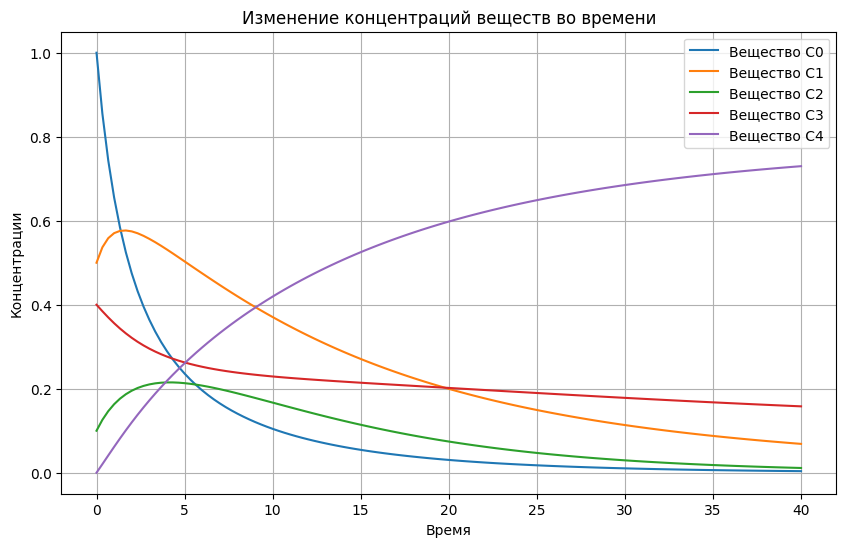

In [6]:
sol = solve_ivp(
        true_ode_func,              # Функция ОДУ
        tspan,                      # Интервал времени
        INIT_CONC,                         # Начальные условия
        args=(k,),                  # Передача параметров в функцию
        method='RK45',              # Метод решения
        t_eval=tsteps               # Точки, в которых сохраняется решение (Шаг)
    )

# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(sol.t, sol.y[i], label=f'Вещество C{i}')

plt.title('Изменение концентраций веществ во времени')
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid()
plt.show()

# Сохранение сгенерированных концентраций C в моменты времени. Понадобятся в будущем
CONC_TRUE = sol.y.copy()

## Добавление шума

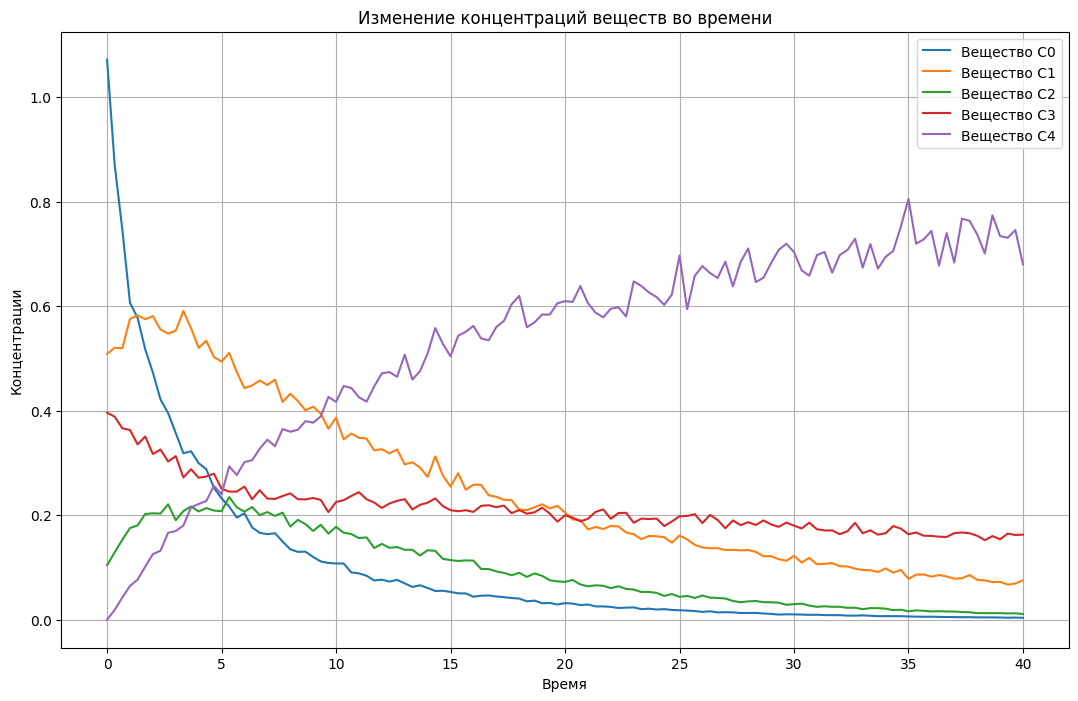

In [7]:
# Генерация шума
noise_level = 4e-2  # Уровень шума

# Создание копии, чтобы работать с ней
y_noisy = sol.y.copy()

# Генерация шума и его добавление
np.random.seed(3)

noise = np.random.normal(0, noise_level * np.abs(y_noisy))          #  это шум
y_noisy += noise                                                    #  это шум

# Построение графиков
plt.figure(figsize=(13, 8))
for i in range(N_SUBSTANCE):
    plt.plot(sol.t, y_noisy[i], label=f'Вещество C{i}')
    # plt.plot(sol.t, sol.y[i])

plt.title('Изменение концентраций веществ во времени')  
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()


### Сохранение данных в нужном формате

In [16]:
data = pd.DataFrame(y_noisy.T)
# df.to_csv("generate_concentrations_1.csv", index=False)
print(data)

            0         1         2         3         4
0    1.071545  0.508529  0.104269  0.396166  0.000000
1    0.870015  0.520497  0.129120  0.388453  0.018909
2    0.746408  0.519515  0.153019  0.366345  0.042637
3    0.606531  0.575575  0.175362  0.363047  0.064584
4    0.577522  0.582371  0.180516  0.335474  0.076770
..        ...       ...       ...       ...       ...
116  0.004427  0.071900  0.012607  0.160028  0.773740
117  0.004219  0.072411  0.012592  0.153935  0.734054
118  0.003867  0.067232  0.012046  0.164848  0.730856
119  0.004075  0.069217  0.012367  0.162161  0.745659
120  0.003637  0.075426  0.010902  0.162753  0.679870

[121 rows x 5 columns]


# Построение аппроксимации

## Сплайнами

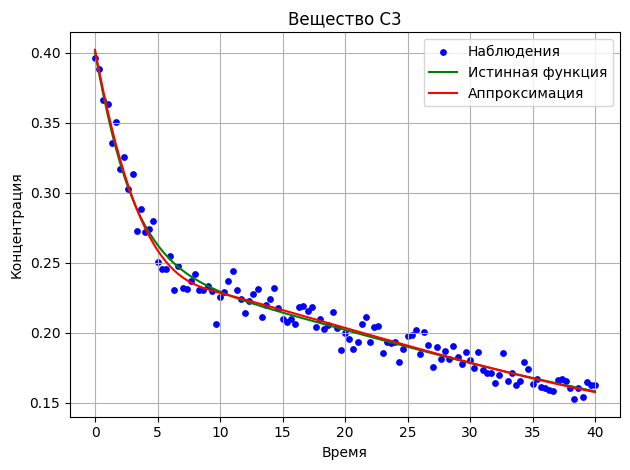

In [14]:
splines = []  # Список для хранения моделей

# Создаем плотную сетку для отображения сплайна
x_dense = np.linspace(0, VR_TIME, len(tsteps) * 1)

# Явное задание узлов разбиения
knots = np.linspace(0, VR_TIME, 7)          
knots = np.delete(knots, [0, -1])           # Узлы должны быть внутри диапазона x, не должны содержать концов

knots_smart = [10.]                # Сделал меньше промежутки в начале, где происходят интенсивные изменения

# Перебираем вещества
for i in [3]:
    y = y_noisy[i]  # Преобразование в 1D массив

    # Создаем и обучаем модель полиномиальной регрессии
    spline = LSQUnivariateSpline(tsteps, y, knots_smart, k=3)
    splines.append(spline)  # Сохраняем модель

    y_pred = spline(x_dense)
    # y_pred = spline(tsteps)

    # Строим график
    plt.scatter(tsteps, y, color='blue', label='Наблюдения', s=15)
    plt.plot(tsteps, CONC_TRUE[i], color='green', label='Истинная функция')
    plt.plot(x_dense, y_pred, color='red', label='Аппроксимация')
    
    # Настройка графика
    plt.title(f'Вещество C{i}')
    plt.xlabel('Время')
    plt.ylabel('Концентрация')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    
    # Вывод коэффициентов
    # r2 = r2_score(CONC_TRUE[i], y_pred)
    # print(f"Вещество C{i}: R^2 = {r2:.6f}")


## Функцией Гамма-распределения

In [23]:
data[0]

0      1.071545
1      0.870015
2      0.746408
3      0.606531
4      0.577522
         ...   
116    0.004427
117    0.004219
118    0.003867
119    0.004075
120    0.003637
Name: 0, Length: 121, dtype: float64

C:\Users\GeraschenkoKM\AppData\Local\Temp\ipykernel_12208\1123699602.py:2: RuntimeWarning: divide by zero encountered in power
  return A * (t ** (k - 1)) * np.exp(-t / theta) / (theta ** k * sp.gamma(k))
C:\Users\GeraschenkoKM\AppData\Local\Temp\ipykernel_12208\1123699602.py:5: RuntimeWarning: divide by zero encountered in reciprocal
  term1 = (k - 1) * t ** (k - 2) * np.exp(-t / theta)
C:\Users\GeraschenkoKM\AppData\Local\Temp\ipykernel_12208\1123699602.py:5: RuntimeWarning: invalid value encountered in multiply
  term1 = (k - 1) * t ** (k - 2) * np.exp(-t / theta)
C:\Users\GeraschenkoKM\AppData\Local\Temp\ipykernel_12208\1123699602.py:5: RuntimeWarning: divide by zero encountered in power
  term1 = (k - 1) * t ** (k - 2) * np.exp(-t / theta)


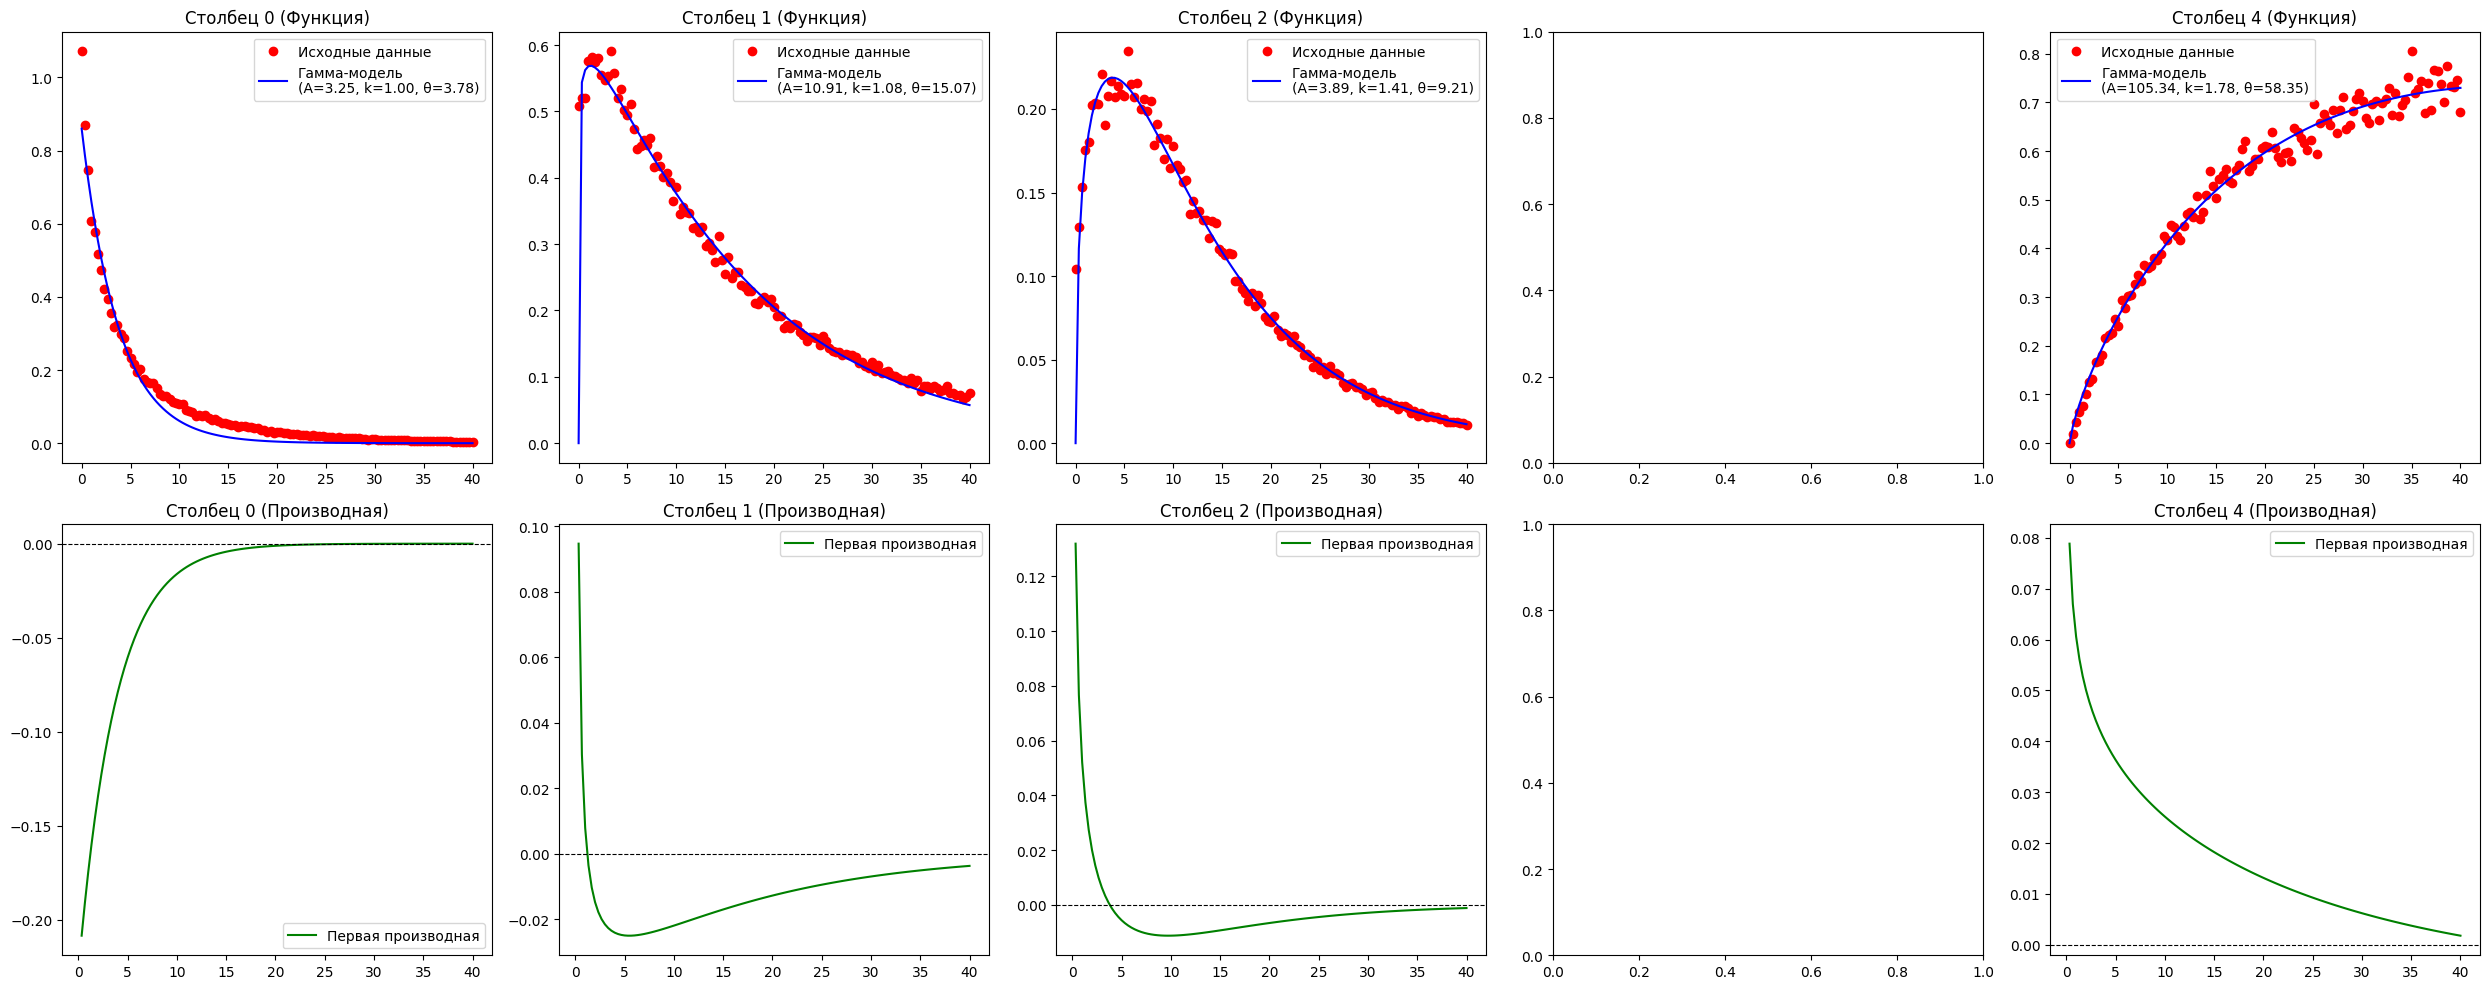

0: A=3.24680, k=1.00000, θ=3.77598
1: A=10.91249, k=1.08020, θ=15.06946
2: A=3.89083, k=1.41375, θ=9.20638
4: A=105.33535, k=1.78379, θ=58.35100


In [ ]:
def gamma_function(t, A, k, theta):
    return A * (t ** (k - 1)) * np.exp(-t / theta) / (theta ** k * sp.gamma(k))

def gamma_derivative(t, A, k, theta):
    term1 = (k - 1) * t ** (k - 2) * np.exp(-t / theta)
    term2 = t ** (k - 1) * np.exp(-t / theta) / theta
    return A * (term1 - term2) / (theta ** k * sp.gamma(k))

num_columns = data.shape[1]
# Создание графиков для каждого столбца
fig, axes = plt.subplots(2, num_columns, figsize=(5 * num_columns, 10))
if num_columns == 1:
    axes = [axes]

for i in [0, 1, 2, 4]:
    column_data = data[i]
    
    # Подбор параметров функции изменения во времени
    params, _ = opt.curve_fit(gamma_function, tsteps[:len(column_data)], column_data, p0=[1, 2, 1])
    A_opt, k_opt, theta_opt = params
    if (k_opt - 1) < 0.01:
        k_opt = 1
    
    # Вычисление функции и её производной
    fit_curve = gamma_function(tsteps, A_opt, k_opt, theta_opt)
    fit_derivative = gamma_derivative(tsteps, A_opt, k_opt, theta_opt)
    
    # Визуализация функции
    axes[0, i].scatter(tsteps, column_data, label='Исходные данные', color='red')
    axes[0, i].plot(tsteps, fit_curve, label=f'Гамма-модель\n(A={A_opt:.2f}, k={k_opt:.2f}, θ={theta_opt:.2f})', color='blue')
    axes[0, i].set_title(f'Столбец {i} (Функция)')
    axes[0, i].legend()
    
    # Визуализация производной
    axes[1, i].plot(tsteps, fit_derivative, label='Первая производная', color='green')
    axes[1, i].set_title(f'Столбец {i} (Производная)')
    axes[1, i].axhline(0, color='black', linestyle='--', linewidth=0.8)
    axes[1, i].legend()

plt.tight_layout()
plt.show()


# Вывод оптимальных параметров для всех столбцов
for column in [0, 1, 2, 4]:
    column_data = data[column]
    params, _ = opt.curve_fit(gamma_function, tsteps[:len(column_data)], column_data, p0=[1, 2, 1])
    A_opt, k_opt, theta_opt = params
    print(f"{column}: A={A_opt:.5f}, k={k_opt:.5f}, θ={theta_opt:.5f}")

# Генерация данных

## Функция для вычисления приращений концентраций веществ

In [ ]:
def true_ode_func(t: float, y: np.ndarray, k: np.ndarray) -> np.ndarray:
    """
    Вычисляет производные системы дифференциальных уравнений.
    
    Параметры:
    t : float
        Время (не используется в данном уравнении, но необходим для совместимости с solve_ivp).
    y : np.array
        Вектор переменных (y[0], y[1], ..., y[4]).
    k : np.array
        Константы скоростей реакций (k[0], k[1], ..., k[4]).

    Возвращает:
    dydt : numpy.ndarray
        Вектор производных.
    """
    
    dydt = np.empty_like(y)                          # можно использовать np.zeros_like(y), но это быстрее
    dydt[0] = -2 * k[0] * y[0]**2 - k[1] * y[0]
    dydt[1] = k[0] * y[0]**2 - k[3] * y[1] * y[3]
    dydt[2] = k[1] * y[0] - k[2] * y[2]
    dydt[3] = k[2] * y[2] - k[3] * y[1] * y[3]
    dydt[4] = k[3] * y[1] * y[3]
    return dydt